# GMM - Dataset Sintético

En éste notebook, vamos a usar el modelo de GMM desarrollado en NumPy usando Expectation Maximization y el dataset sintético armado, para evaluar el algoritmo y compararlo con K-means.

## Cargamos las Librerías

In [1]:
import numpy as np
import seaborn as sns
from scipy.stats import multivariate_normal
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib as mpl


In [2]:
import sys  
#sys.path.insert(0, 'clase_3/ejercicios/src')
#sys.path.insert(0, 'clase_1/ejercicios/src')
sys.path.insert(0, 'modulos/')

In [3]:
from models import BaseModel
from metrics import Accuracy, Precision, Recall
from k_means_numpy import k_means, k_means_classify
from SyntheticDataset import SyntheticDataset
#from EM_Numpy import EMScalar

## Cargamos el Dataset
El dataset sintético posee las siguientes características:

$p(x/z=0)\sim \mathcal{N}(20, 5)$

$p(x/z=1)\sim \mathcal{N}(3, 8)$

$P(z=0)=0.4$

$P(z=1)=0.6$

Las distribuciones se encuentran más separadas entre sí que las originales. Con estas condiciones, el método para el cálculo EM considerará un k=2, que representa la cantidad de distribuciones a clusterizar.

In [4]:
# Creamos el dataset

# Establecemos los parámetros de las GMM
mu = np.array([20, 5])
var = np.array([3, 8])
p = 0.4

dataset = SyntheticDataset(mu, var, p, 700)
x_train, x_test, y_train, y_test = dataset.split(0.8)
x_train.shape

(560,)

In [5]:
x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)

In [6]:
class EMScalar(BaseModel):
    
    def fit(self,X,MAX_IT,k):
        # Los parámetros deben incluir al menos:
        #  - Alguna forma de detener la iteración: MAX_IT
        #  - Los datos observados: X
        #  - La cantidad de distribuciones: k
        n = X.shape[0]
            
        # Inicializar las probabilidades marginales de las clases P(z)
        # Se plantea como distribución a priori una uniforme
        #p = np.ones(k) / k
        # Otra distribución
        p = np.random.uniform(0, 1, (k, 1))
        p = p / np.sum(p, axis=0)
        
        # Inicializar medias
        means = np.random.uniform(np.min(X), np.max(X), (k, 1))
        
        # Inicializar matrices covarianza
        covariance = np.sum((np.hstack((X, X))- means.T)**2, axis=0)/(X.shape[0]-1)
        covariance = covariance.reshape(-1, 1)
        
        # Crear matrices place-holders para 
            # p(x|z) para cada clase z (n x k), [p(x1|z1) p(x1|z2) p(x1|z3) ..]
            # Responsibilities
        Nij = np.zeros((n, k))
        Eij = np.zeros((n, k))
        Eij_ant = np.zeros((n, k))
        
        i = 0
        delta = False
        tol = 1E-5

        # Calcular, con los parámetros iniciales, p(x|z) para todos los z
        for j in range(k):
            Nij[:, j] = multivariate_normal.pdf(X, means[j], covariance[j])
        
        while not (delta or i > MAX_IT): # Criterio para detener:
            Eij_ant[:, :] = Eij
            for j in range(k):
                # Responsibilities
                Eij[:, j] = (p[j] * Nij[:, j]) / (Nij @ p)[:, 0]
                # Actualizar medias 
                means[j] = (Eij[:, j].dot(X)) / np.sum(Eij[:, j], axis=0)
                # Actualizar covarianzas
                covariance[j] = Eij[:, j].dot((X - means[j]) * (X - means[j])) / np.sum(Eij[:, j])
                # Actualizar pesos de clases
                p[j] = np.mean(Eij[:, j])
                # Actualizar p(x|z)
                Nij[:, j] = multivariate_normal.pdf(X, means[j], covariance[j])
            delta = np.allclose(Eij_ant, Eij, rtol=tol)
            i = i + 1
        idx = np.argsort(means[:, 0], axis=0)
        
        # Al finalizar el loop, guardar el modelo en la clase
        self.model = {'mu': means[idx, :], 'cov': covariance[idx, :], 'p': p[idx, :]}

    def predict(self, X):
        # Devuelve para cada observación la clase asignada
        k = self.model['mu'].shape[0]
        N = np.zeros((X.shape[0], k))
        E = np.zeros((X.shape[0], k))

        for i in range(k):
            N[:, i] = multivariate_normal.pdf(X, self.model['mu'][i, 0], self.model['cov'][i, 0])
        for i in range(k):
            E[:, i] = (self.model['p'][i, 0] * N[:, i]) / (N @ self.model['p'])[:, 0]
        idx = np.argmax(E, axis=1)
        return idx

## Cargamos los Modelos

In [7]:
# Model fit y predict

EM = EMScalar()
#Parametros de entrada al fit
#Iteraciones máximas
MAX_IT = 200
k = 2
EM.fit(x_train,MAX_IT,k)
predictions = EM.predict(x_test)

In [8]:
print("Expectation Maximization\n")

print("Means: ")
print(EM.model['mu'], "\n")

print("Covariance: ")
print(EM.model['cov'], "\n")

print("Probabilities: ")
print(EM.model['p'], "\n")

metrics = [Precision(), Accuracy(), Recall()]

for metric in metrics:
    print('{}: {:.2f}'.format(metric.__class__.__name__, metric(y_test, predictions)))

Expectation Maximization

Means: 
[[ 4.51139175]
 [19.32907706]] 

Covariance: 
[[60.3788861 ]
 [10.37377625]] 

Probabilities: 
[[0.56770867]
 [0.43229146]] 

Precision: 0.13
Accuracy: 0.07
Recall: 0.10


In [9]:
# Comparamos los resultados con K-means

print("K-means")

centers, ids = k_means(x_train, 2)
k_predictions = k_means_classify(x_test, centers)

k_predictions = np.where((k_predictions==0)|(k_predictions==1), k_predictions^1, k_predictions)

for metric in metrics:
    print('{}: {:.2f}'.format(metric.__class__.__name__, metric(y_test, k_predictions)))

K-means
Precision: 0.27
Accuracy: 0.15
Recall: 0.25


### Gráficas

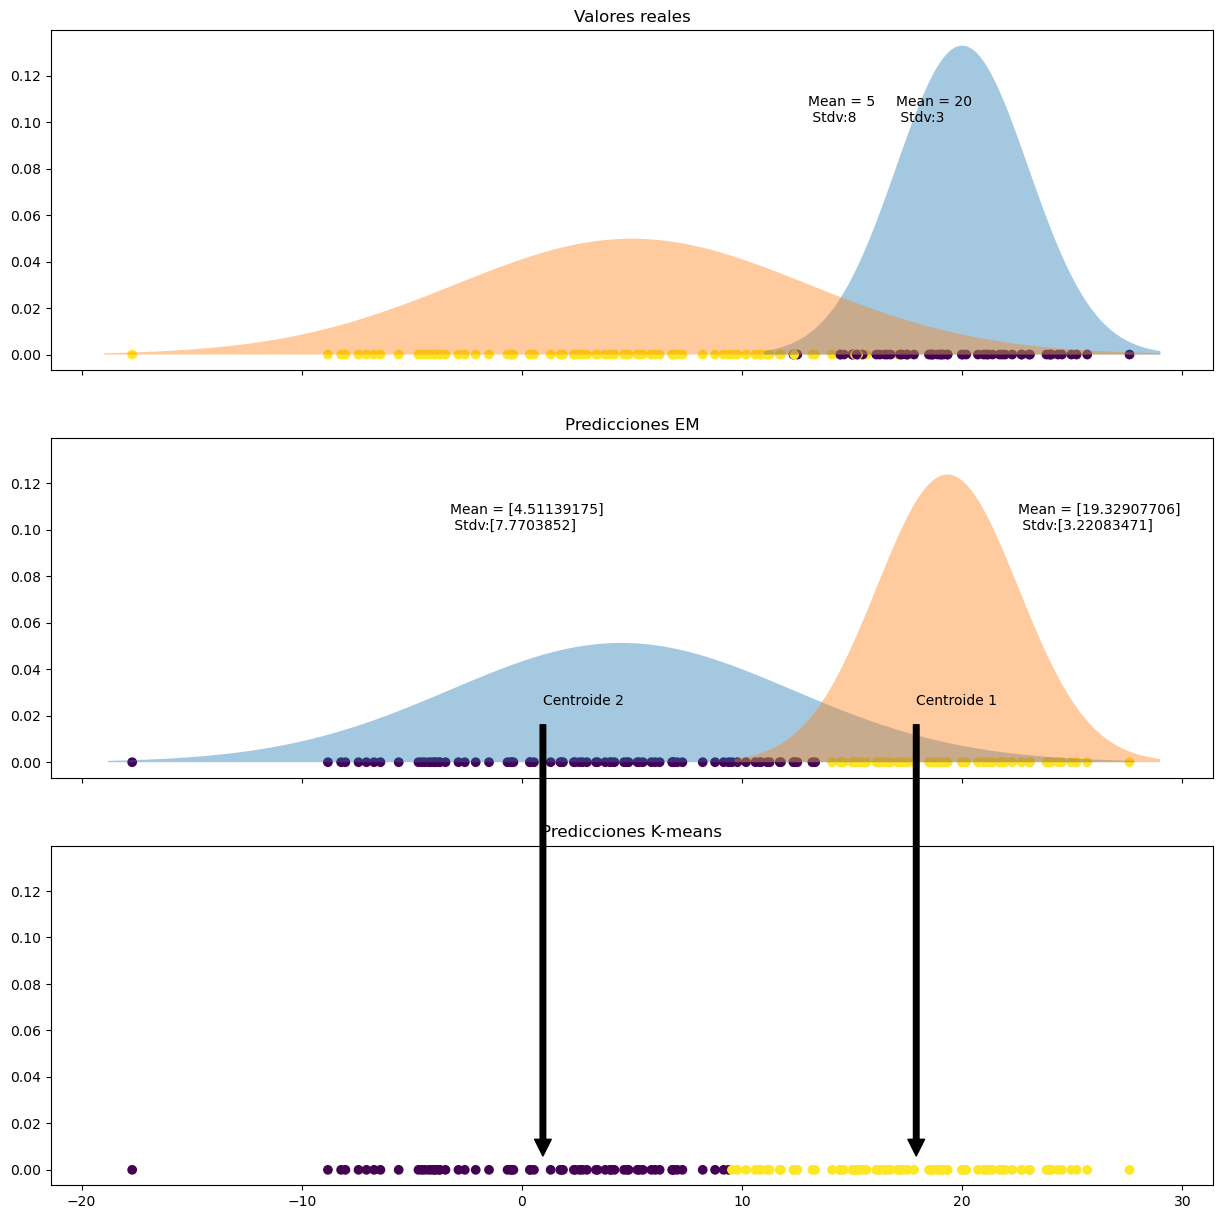

In [10]:
# Plots
mpl.rc_file_defaults()
f, (ax, bx, cx) = plt.subplots(3, 1, sharey='col', sharex='col', figsize=(15, 15))

ax.scatter(x_test[:, 0], np.zeros_like(x_test), c=y_test, alpha=1)
xr_1 = np.linspace(mu[0] - 3 * var[0], mu[0] + 3 * var[0], 100)
xr_2 = np.linspace(mu[1] - 3 * var[1], mu[1] + 3 * var[1], 100)
density_r1 = norm.pdf(xr_1, loc=mu[0], scale=var[0])
density_r2 = norm.pdf(xr_2, loc=mu[1], scale=var[1])
ax.fill_between(xr_1, density_r1, alpha=0.4)
ax.fill_between(xr_2, density_r2, alpha=0.4)
ax.text(mu[0] - 1 * var[0], 0.1, 'Mean = {media}\n Stdv:{std}'.format(media=mu[0], std=var[0]))
ax.text(mu[1] + 1 * var[1], 0.1, 'Mean = {media}\n Stdv:{std}'.format(media=mu[1], std=var[1]))
ax.set_title('Valores reales')

bx.scatter(x_test[:, 0], np.zeros_like(x_test), c=predictions, alpha=1)
x_1 = np.linspace(EM.model['mu'][0] - 3 * (EM.model['cov'][0] ** 0.5),
                  EM.model['mu'][0] + 3 * (EM.model['cov'][0] ** 0.5), 100)
x_2 = np.linspace(EM.model['mu'][1] - 3 * (EM.model['cov'][1] ** 0.5),
                  EM.model['mu'][1] + 3 * (EM.model['cov'][1] ** 0.5), 100)
density_1 = norm.pdf(x_1[:, 0], loc=EM.model['mu'][0], scale=EM.model['cov'][0] ** 0.5)
density_2 = norm.pdf(x_2[:, 0], loc=EM.model['mu'][1], scale=EM.model['cov'][1] ** 0.5)
bx.fill_between(x_1[:, 0], density_1, alpha=0.4)
bx.fill_between(x_2[:, 0], density_2, alpha=0.4)
bx.set_title('Predicciones EM')
bx.text(EM.model['mu'][0] - 1 * EM.model['cov'][0] ** 0.5, 0.1,
        'Mean = {media}\n Stdv:{std}'.format(media=EM.model['mu'][0], std=EM.model['cov'][0] ** 0.5))
bx.text(EM.model['mu'][1] + 1 * EM.model['cov'][1] ** 0.5, 0.1,
        'Mean = {media}\n Stdv:{std}'.format(media=EM.model['mu'][1], std=EM.model['cov'][1] ** 0.5))

cx.scatter(x_test[:, 0], np.zeros_like(x_test), c=k_predictions, alpha=1)
cx.set_title('Predicciones K-means')
cx.annotate('Centroide 1', xy=(centers[0], 0), xytext=(centers[0], 0.2),
            arrowprops=dict(facecolor='black', shrink=0.03))
cx.annotate('Centroide 2', xy=(centers[1], 0), xytext=(centers[1], 0.2),
            arrowprops=dict(facecolor='black', shrink=0.03))

plt.show()
